In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from adjustText import adjust_text
from ampligraph.discovery import find_clusters
from ampligraph.evaluation import (
    hits_at_n_score,
    mr_score,
    mrr_score,
    train_test_split_no_unseen,
)
from ampligraph.latent_features import ScoringBasedEmbeddingModel
from ampligraph.latent_features.loss_functions import get as get_loss
from ampligraph.latent_features.regularizers import get as get_regularizer
from rdflib import Graph, Literal
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


In [4]:
!git clone https://github.com/wyldebeast-wunderliebe/incf.countryutils.git
!cd incf.countryutils && pip install .

fatal: destination path 'incf.countryutils' already exists and is not an empty directory.
Processing /home/kxrxh/Dev/ITMO/knowladgegraph/src/embedding/incf.countryutils
  Preparing metadata (setup.py) ... done
  Created wheel for incf.countryutils: filename=incf.countryutils-1.2-py3-none-any.whl size=21367 sha256=2597fd4dacc65247eca92aa5537a0bf96de53cbf5ac3e12866cb209537e1a275
  Stored in directory: /tmp/pip-ephem-wheel-cache-9qp89bb2/wheels/ba/2a/76/3a8c8d7c9d6d697b629896cd2e2c5fac14770c8339d482216d
Successfully built incf.countryutils
  Attempting uninstall: incf.countryutils
    Found existing installation: incf.countryutils 1.2
    Uninstalling incf.countryutils-1.2:
      Successfully uninstalled incf.countryutils-1.2


In [5]:
# Load the Minecraft ontology graph
GRAPH_FILE = "../data/minecraft.owl"
g = Graph()
g.parse(GRAPH_FILE, format="xml")

# Universal implementation of RML approach to convert graph to triples
triples = []

# Function to create nodes and triples from a given subject, predicate, and object
def create_triples(subject, predicate, object_):
    subject_name = str(subject).split("/")[-1] if str(subject).startswith("http://minecraft.example.org/") else str(subject)
    predicate_name = str(predicate).split("/")[-1] if str(predicate).startswith("http://minecraft.example.org/") else str(predicate).split("#")[-1] if "#" in str(predicate) else str(predicate).split("/")[-1]
    object_name = str(object_).split("/")[-1] if str(object_).startswith("http://minecraft.example.org/") else str(object_).split("#")[-1] if "#" in str(object_) else str(object_).split("/")[-1]
    
    # Add triple if all parts are valid
    if subject_name and predicate_name and object_name:
        triples.append([subject_name, predicate_name, object_name])

# Iterate through the graph to extract triples
for s, p, o in g:
    if not isinstance(o, Literal):  # Skip literals
        create_triples(s, p, o)

# Convert to numpy array and split into train/test sets
triples_array = np.array(triples)
X_train, X_valid = train_test_split_no_unseen(triples_array, test_size=0.2)

# Create DataFrame for analysis
df = pd.DataFrame(triples, columns=["subject", "predicate", "object"])

print(f"Total number of triples: {len(triples)}")
print(f"Train set size: {X_train.shape}")
print(f"Test set size: {X_valid.shape}")

# Set device to GPU if available
device = "/GPU:0" if tf.config.list_physical_devices('GPU') else "/CPU:0"
print(f"Using device: {device}")

with tf.device(device):
    # Initialize ComplEx embedding model
    model = ScoringBasedEmbeddingModel(
        k=100,  # Embedding dimension
        eta=20,  # Number of negative samples
        scoring_type="ComplEx",
        seed=0
    )

    # Configure training parameters
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)
    loss = get_loss("multiclass_nll")
    regularizer = get_regularizer("LP", {"p": 3, "lambda": 1e-5})
    
    model.compile(
        optimizer=optimizer,
        loss=loss,
        entity_relation_regularizer=regularizer
    )

    # Train the model
    model.fit(
        x=X_train,
        batch_size=X_train.shape[0] // 50,
        epochs=400,
        verbose=True,
        validation_data=X_valid,
        shuffle=True
    )

    # Evaluate model performance
    ranks = model.evaluate(
        X_valid,
        use_filter={"train": X_train, "test": X_valid},
        corrupt_side="s,o",
        verbose=True
    )


Total number of triples: 488
Train set size: (391, 3)
Test set size: (97, 3)
Using device: /CPU:0
Epoch 1/400


2024-12-09 20:05:45.365009: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-12-09 20:05:45.380179: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2024-12-09 20:05:45.526414: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Pla

57/57 [==============================] - 1s 22ms/step - loss: 21.2519
Epoch 2/400
57/57 [==============================] - 0s 988us/step - loss: 21.2489
Epoch 3/400
57/57 [==============================] - 0s 1ms/step - loss: 21.2445
Epoch 4/400
 2/57 [>.............................] - ETA: 0s - loss: 21.2450

2024-12-09 20:05:46.833787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:46.914227: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:46.995944: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 959us/step - loss: 21.2403
Epoch 5/400
57/57 [==============================] - 0s 940us/step - loss: 21.2360
Epoch 6/400
57/57 [==============================] - 0s 939us/step - loss: 21.2317
Epoch 7/400
 2/57 [>.............................] - ETA: 0s - loss: 21.2319

2024-12-09 20:05:47.074925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:47.151887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:47.228721: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 945us/step - loss: 21.2271
Epoch 8/400
57/57 [==============================] - 0s 929us/step - loss: 21.2225
Epoch 9/400
57/57 [==============================] - 0s 935us/step - loss: 21.2178
Epoch 10/400
 2/57 [>.............................] - ETA: 0s - loss: 21.2179

2024-12-09 20:05:47.305904: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:47.381759: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:47.458035: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:47.54

57/57 [==============================] - 1s 20ms/step - loss: 21.2131 - val_mrr: 0.0236 - val_mr: 88.4742 - val_hits@1: 0.0000e+00 - val_hits@10: 0.0515 - val_hits@100: 0.5515
Epoch 11/400
57/57 [==============================] - 0s 948us/step - loss: 21.2083
Epoch 12/400
 2/57 [>.............................] - ETA: 0s - loss: 21.2084

2024-12-09 20:05:48.556445: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:48.626955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:48.705020: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 988us/step - loss: 21.2034
Epoch 13/400
57/57 [==============================] - 0s 964us/step - loss: 21.1985
Epoch 14/400
57/57 [==============================] - 0s 1ms/step - loss: 21.1934
Epoch 15/400
 2/57 [>.............................] - ETA: 0s - loss: 21.1935

2024-12-09 20:05:48.786210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:48.865241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:48.947989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 21.1883
Epoch 16/400
57/57 [==============================] - 0s 1ms/step - loss: 21.1831
Epoch 17/400
57/57 [==============================] - 0s 1ms/step - loss: 21.1777
Epoch 18/400
 2/57 [>.............................] - ETA: 0s - loss: 21.1777

2024-12-09 20:05:49.031267: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:49.118559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:49.206924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 21.1721
Epoch 19/400
57/57 [==============================] - 0s 992us/step - loss: 21.1664
Epoch 20/400
 2/57 [>.............................] - ETA: 0s - loss: 21.1664

2024-12-09 20:05:49.290924: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:49.371031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:49.452428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 21.1606 - val_mrr: 0.0278 - val_mr: 83.1186 - val_hits@1: 0.0000e+00 - val_hits@10: 0.0515 - val_hits@100: 0.6392
Epoch 21/400
57/57 [==============================] - 0s 1ms/step - loss: 21.1546
Epoch 22/400
 2/57 [>.............................] - ETA: 0s - loss: 21.1545

2024-12-09 20:05:49.548981: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:49.623591: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:49.711149: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 21.1484
Epoch 23/400
57/57 [==============================] - 0s 1ms/step - loss: 21.1419
Epoch 24/400
57/57 [==============================] - 0s 1ms/step - loss: 21.1354


2024-12-09 20:05:49.804138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:49.903801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:49.996246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 25/400
57/57 [==============================] - 0s 1ms/step - loss: 21.1287
Epoch 26/400
57/57 [==============================] - 0s 1ms/step - loss: 21.1217
Epoch 27/400
57/57 [==============================] - 0s 1ms/step - loss: 21.1145
Epoch 28/400
 2/57 [>.............................] - ETA: 0s - loss: 21.1144

2024-12-09 20:05:50.083503: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:50.172509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:50.264996: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 21.1070
Epoch 29/400
57/57 [==============================] - 0s 1ms/step - loss: 21.0992
Epoch 30/400
 2/57 [>.............................] - ETA: 0s - loss: 21.0992

2024-12-09 20:05:50.346926: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:50.428452: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:50.510746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 21.0912 - val_mrr: 0.0434 - val_mr: 73.8660 - val_hits@1: 0.0000e+00 - val_hits@10: 0.0979 - val_hits@100: 0.7165
Epoch 31/400
57/57 [==============================] - 0s 1ms/step - loss: 21.0829
Epoch 32/400
 2/57 [>.............................] - ETA: 0s - loss: 21.0829

2024-12-09 20:05:50.622035: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:50.699579: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:50.786487: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 21.0743
Epoch 33/400
57/57 [==============================] - 0s 1ms/step - loss: 21.0655
Epoch 34/400
57/57 [==============================] - 0s 1ms/step - loss: 21.0563


2024-12-09 20:05:50.874408: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:50.964728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:51.062307: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 35/400
57/57 [==============================] - 0s 1ms/step - loss: 21.0467
Epoch 36/400
57/57 [==============================] - 0s 2ms/step - loss: 21.0367
Epoch 37/400
 2/57 [>.............................] - ETA: 0s - loss: 21.0366

2024-12-09 20:05:51.160107: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:51.318044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 2ms/step - loss: 21.0265
Epoch 38/400
57/57 [==============================] - 0s 1ms/step - loss: 21.0158
Epoch 39/400
57/57 [==============================] - 0s 1ms/step - loss: 21.0047
Epoch 40/400
 2/57 [>.............................] - ETA: 0s - loss: 21.0046

2024-12-09 20:05:51.448168: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:51.533628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:51.621052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 20.9933 - val_mrr: 0.0757 - val_mr: 63.1598 - val_hits@1: 0.0000e+00 - val_hits@10: 0.1598 - val_hits@100: 0.7629
Epoch 41/400
 2/57 [>.............................] - ETA: 0s - loss: 20.9931

2024-12-09 20:05:51.713209: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:51.810804: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:51.891484: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 20.9813
Epoch 42/400
57/57 [==============================] - 0s 1ms/step - loss: 20.9689
Epoch 43/400
57/57 [==============================] - 0s 1ms/step - loss: 20.9562
Epoch 44/400
 2/57 [>.............................] - ETA: 0s - loss: 20.9560

2024-12-09 20:05:51.980335: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:52.065093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:52.152530: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 20.9430
Epoch 45/400
57/57 [==============================] - 0s 1ms/step - loss: 20.9291
Epoch 46/400
57/57 [==============================] - 0s 999us/step - loss: 20.9147
Epoch 47/400
 2/57 [>.............................] - ETA: 0s - loss: 20.9146

2024-12-09 20:05:52.237845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:52.319922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:52.400680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 2ms/step - loss: 20.9000
Epoch 48/400
57/57 [==============================] - 0s 1ms/step - loss: 20.8847
Epoch 49/400
57/57 [==============================] - 0s 980us/step - loss: 20.8688
Epoch 50/400
 2/57 [>.............................] - ETA: 0s - loss: 20.8686

2024-12-09 20:05:52.512651: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:52.607391: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:52.687120: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 20.8523 - val_mrr: 0.1043 - val_mr: 54.9485 - val_hits@1: 0.0000e+00 - val_hits@10: 0.2371 - val_hits@100: 0.7990
Epoch 51/400
 2/57 [>.............................] - ETA: 0s - loss: 20.8521

2024-12-09 20:05:52.767380: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:52.865349: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:52.940812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 952us/step - loss: 20.8352
Epoch 52/400
57/57 [==============================] - 0s 998us/step - loss: 20.8174
Epoch 53/400
57/57 [==============================] - 0s 957us/step - loss: 20.7990
Epoch 54/400
 2/57 [>.............................] - ETA: 0s - loss: 20.7988

2024-12-09 20:05:53.019403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:53.100833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:53.181512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 967us/step - loss: 20.7800
Epoch 55/400
57/57 [==============================] - 0s 986us/step - loss: 20.7603
Epoch 56/400
57/57 [==============================] - 0s 1ms/step - loss: 20.7400
Epoch 57/400
 2/57 [>.............................] - ETA: 0s - loss: 20.7397

2024-12-09 20:05:53.260927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:53.341214: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:53.424772: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 20.7189
Epoch 58/400
57/57 [==============================] - 0s 1ms/step - loss: 20.6971
Epoch 59/400
57/57 [==============================] - 0s 1ms/step - loss: 20.6747
Epoch 60/400
 2/57 [>.............................] - ETA: 0s - loss: 20.6744

2024-12-09 20:05:53.524180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:53.608945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:53.698802: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 20.6516 - val_mrr: 0.1315 - val_mr: 49.5361 - val_hits@1: 0.0000e+00 - val_hits@10: 0.2887 - val_hits@100: 0.8093
Epoch 61/400
 2/57 [>.............................] - ETA: 0s - loss: 20.6513

2024-12-09 20:05:53.787899: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:53.883352: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:53.955191: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 994us/step - loss: 20.6276
Epoch 62/400
57/57 [==============================] - 0s 1ms/step - loss: 20.6028
Epoch 63/400
57/57 [==============================] - 0s 950us/step - loss: 20.5771
Epoch 64/400
 2/57 [>.............................] - ETA: 0s - loss: 20.5767

2024-12-09 20:05:54.037038: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:54.118812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:54.196900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 969us/step - loss: 20.5509
Epoch 65/400
57/57 [==============================] - 0s 991us/step - loss: 20.5238
Epoch 66/400
57/57 [==============================] - 0s 970us/step - loss: 20.4959
Epoch 67/400
 2/57 [>.............................] - ETA: 0s - loss: 20.4955

2024-12-09 20:05:54.277483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:54.361641: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:54.441061: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 20.4669
Epoch 68/400
57/57 [==============================] - 0s 1ms/step - loss: 20.4373
Epoch 69/400
57/57 [==============================] - 0s 997us/step - loss: 20.4070
Epoch 70/400
 2/57 [>.............................] - ETA: 0s - loss: 20.4065

2024-12-09 20:05:54.524036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:54.608668: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:54.690263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 20.3758 - val_mrr: 0.1516 - val_mr: 46.0619 - val_hits@1: 0.0000e+00 - val_hits@10: 0.3608 - val_hits@100: 0.8299
Epoch 71/400
 2/57 [>.............................] - ETA: 0s - loss: 20.3754

2024-12-09 20:05:54.771959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:54.864090: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:54.934124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 952us/step - loss: 20.3434
Epoch 72/400
57/57 [==============================] - 0s 1ms/step - loss: 20.3105
Epoch 73/400
57/57 [==============================] - 0s 1ms/step - loss: 20.2765
Epoch 74/400
 2/57 [>.............................] - ETA: 0s - loss: 20.2761

2024-12-09 20:05:55.011755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:55.101927: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:55.189248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 20.2419
Epoch 75/400
57/57 [==============================] - 0s 1ms/step - loss: 20.2061
Epoch 76/400
57/57 [==============================] - 0s 944us/step - loss: 20.1696
Epoch 77/400
 2/57 [>.............................] - ETA: 0s - loss: 20.1691

2024-12-09 20:05:55.270375: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:55.356428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:55.435852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 989us/step - loss: 20.1322
Epoch 78/400
57/57 [==============================] - 0s 995us/step - loss: 20.0943
Epoch 79/400
57/57 [==============================] - 0s 940us/step - loss: 20.0550
Epoch 80/400
 2/57 [>.............................] - ETA: 0s - loss: 20.0545

2024-12-09 20:05:55.517053: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:55.598495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:55.675782: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 20.0150 - val_mrr: 0.1662 - val_mr: 43.9021 - val_hits@1: 0.0000e+00 - val_hits@10: 0.3918 - val_hits@100: 0.8351
Epoch 81/400
 2/57 [>.............................] - ETA: 0s - loss: 20.0144

2024-12-09 20:05:55.757369: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:55.854595: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:55.925404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 988us/step - loss: 19.9742
Epoch 82/400
57/57 [==============================] - 0s 1ms/step - loss: 19.9321
Epoch 83/400
57/57 [==============================] - 0s 978us/step - loss: 19.8891
Epoch 84/400
 2/57 [>.............................] - ETA: 0s - loss: 19.8885

2024-12-09 20:05:56.005605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:56.087029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:56.166748: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 985us/step - loss: 19.8456
Epoch 85/400
57/57 [==============================] - 0s 1000us/step - loss: 19.8010
Epoch 86/400
57/57 [==============================] - 0s 968us/step - loss: 19.7556
Epoch 87/400
 2/57 [>.............................] - ETA: 0s - loss: 19.7549

2024-12-09 20:05:56.249812: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:56.331879: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:56.412070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 19.7087
Epoch 88/400
57/57 [==============================] - 0s 1ms/step - loss: 19.6616
Epoch 89/400
57/57 [==============================] - 0s 1ms/step - loss: 19.6143
Epoch 90/400
 2/57 [>.............................] - ETA: 0s - loss: 19.6136

2024-12-09 20:05:56.494556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:56.577373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:56.659126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 19.5650 - val_mrr: 0.1796 - val_mr: 42.0464 - val_hits@1: 0.0000e+00 - val_hits@10: 0.4175 - val_hits@100: 0.8299
Epoch 91/400
 2/57 [>.............................] - ETA: 0s - loss: 19.5643

2024-12-09 20:05:56.745505: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:56.839538: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:56.916253: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 19.5157
Epoch 92/400
57/57 [==============================] - 0s 1ms/step - loss: 19.4655
Epoch 93/400
57/57 [==============================] - 0s 1ms/step - loss: 19.4140
Epoch 94/400
 2/57 [>.............................] - ETA: 0s - loss: 19.4132

2024-12-09 20:05:56.997500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:57.089574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:57.173466: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 975us/step - loss: 19.3626
Epoch 95/400
57/57 [==============================] - 0s 1ms/step - loss: 19.3102
Epoch 96/400
57/57 [==============================] - 0s 1ms/step - loss: 19.2569
Epoch 97/400
 2/57 [>.............................] - ETA: 0s - loss: 19.2562

2024-12-09 20:05:57.255767: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:57.338413: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:57.426948: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 955us/step - loss: 19.2027
Epoch 98/400
57/57 [==============================] - 0s 989us/step - loss: 19.1476
Epoch 99/400
57/57 [==============================] - 0s 1ms/step - loss: 19.0925
Epoch 100/400
 2/57 [>.............................] - ETA: 0s - loss: 19.0917

2024-12-09 20:05:57.504862: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:57.586062: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:57.668031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 19.0361 - val_mrr: 0.1893 - val_mr: 40.5103 - val_hits@1: 0.0000e+00 - val_hits@10: 0.4433 - val_hits@100: 0.8402
Epoch 101/400
 2/57 [>.............................] - ETA: 0s - loss: 19.0353

2024-12-09 20:05:57.756128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:57.853228: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:57.929121: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 988us/step - loss: 18.9796
Epoch 102/400
57/57 [==============================] - 0s 1ms/step - loss: 18.9223
Epoch 103/400
57/57 [==============================] - 0s 984us/step - loss: 18.8637
Epoch 104/400
 2/57 [>.............................] - ETA: 0s - loss: 18.8630

2024-12-09 20:05:58.010439: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:58.093372: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:58.174098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 18.8044
Epoch 105/400
57/57 [==============================] - 0s 978us/step - loss: 18.7444
Epoch 106/400
57/57 [==============================] - 0s 972us/step - loss: 18.6846
Epoch 107/400
 2/57 [>.............................] - ETA: 0s - loss: 18.6837

2024-12-09 20:05:58.257449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:58.337138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:58.416405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 18.6242
Epoch 108/400
57/57 [==============================] - 0s 1ms/step - loss: 18.5633
Epoch 109/400
57/57 [==============================] - 0s 1ms/step - loss: 18.5011
Epoch 110/400
 2/57 [>.............................] - ETA: 0s - loss: 18.5003

2024-12-09 20:05:58.499048: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:58.579997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:58.662427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 18.4397 - val_mrr: 0.1942 - val_mr: 39.3196 - val_hits@1: 0.0000e+00 - val_hits@10: 0.4588 - val_hits@100: 0.8402
Epoch 111/400
 2/57 [>.............................] - ETA: 0s - loss: 18.4389

2024-12-09 20:05:58.740469: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:58.835023: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:58.905051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 945us/step - loss: 18.3772
Epoch 112/400
57/57 [==============================] - 0s 942us/step - loss: 18.3140
Epoch 113/400
57/57 [==============================] - 0s 915us/step - loss: 18.2508
Epoch 114/400
 2/57 [>.............................] - ETA: 0s - loss: 18.2499

2024-12-09 20:05:58.982678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:59.060311: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:59.135308: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 922us/step - loss: 18.1875
Epoch 115/400
57/57 [==============================] - 0s 910us/step - loss: 18.1239
Epoch 116/400
57/57 [==============================] - 0s 914us/step - loss: 18.0589
Epoch 117/400
 2/57 [>.............................] - ETA: 0s - loss: 18.0580

2024-12-09 20:05:59.210592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:59.285137: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:59.359642: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 924us/step - loss: 17.9946
Epoch 118/400
57/57 [==============================] - 0s 924us/step - loss: 17.9306
Epoch 119/400
57/57 [==============================] - 0s 932us/step - loss: 17.8643
Epoch 120/400
 2/57 [>.............................] - ETA: 0s - loss: 17.8633

2024-12-09 20:05:59.435569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:59.511795: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:59.588724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 17.7985 - val_mrr: 0.1969 - val_mr: 38.4227 - val_hits@1: 0.0000e+00 - val_hits@10: 0.4639 - val_hits@100: 0.8351
Epoch 121/400
 2/57 [>.............................] - ETA: 0s - loss: 17.7976

2024-12-09 20:05:59.670142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:59.763962: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:05:59.833445: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 926us/step - loss: 17.7337
Epoch 122/400
57/57 [==============================] - 0s 913us/step - loss: 17.6682
Epoch 123/400
57/57 [==============================] - 0s 932us/step - loss: 17.6032
Epoch 124/400
 2/57 [>.............................] - ETA: 0s - loss: 17.6022

2024-12-09 20:05:59.910196: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:05:59.985755: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:00.061976: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 919us/step - loss: 17.5364
Epoch 125/400
57/57 [==============================] - 0s 921us/step - loss: 17.4701
Epoch 126/400
57/57 [==============================] - 0s 919us/step - loss: 17.4039
Epoch 127/400
 2/57 [>.............................] - ETA: 0s - loss: 17.4030

2024-12-09 20:06:00.137288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:00.213051: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:00.288403: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 920us/step - loss: 17.3379
Epoch 128/400
57/57 [==============================] - 0s 998us/step - loss: 17.2710
Epoch 129/400
57/57 [==============================] - 0s 920us/step - loss: 17.2040
Epoch 130/400
 2/57 [>.............................] - ETA: 0s - loss: 17.2028

2024-12-09 20:06:00.364047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:00.447012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:00.523282: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 17.1367 - val_mrr: 0.2010 - val_mr: 37.6804 - val_hits@1: 0.0000e+00 - val_hits@10: 0.4691 - val_hits@100: 0.8351
Epoch 131/400
 2/57 [>.............................] - ETA: 0s - loss: 17.1358

2024-12-09 20:06:00.602739: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:00.697497: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/RowPartitionFromRowLengths/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_8
2024-12-09 20:06:00.765801: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 935us/step - loss: 17.0707
Epoch 132/400
57/57 [==============================] - 0s 918us/step - loss: 17.0035
Epoch 133/400
57/57 [==============================] - 0s 928us/step - loss: 16.9370
Epoch 134/400
 2/57 [>.............................] - ETA: 0s - loss: 16.9361

2024-12-09 20:06:00.842986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:00.918938: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:00.995197: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 937us/step - loss: 16.8703
Epoch 135/400
57/57 [==============================] - 0s 911us/step - loss: 16.8027
Epoch 136/400
57/57 [==============================] - 0s 923us/step - loss: 16.7357
Epoch 137/400
 2/57 [>.............................] - ETA: 0s - loss: 16.7347

2024-12-09 20:06:01.072378: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:01.147241: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:01.225039: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 916us/step - loss: 16.6692
Epoch 138/400
57/57 [==============================] - 0s 916us/step - loss: 16.6024
Epoch 139/400
57/57 [==============================] - 0s 919us/step - loss: 16.5357
Epoch 140/400
 2/57 [>.............................] - ETA: 0s - loss: 16.5348

2024-12-09 20:06:01.300813: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:01.376592: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:01.452478: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 16.4688 - val_mrr: 0.2047 - val_mr: 36.9691 - val_hits@1: 0.0000e+00 - val_hits@10: 0.4845 - val_hits@100: 0.8402
Epoch 141/400
 2/57 [>.............................] - ETA: 0s - loss: 16.4679

2024-12-09 20:06:01.530822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:01.623018: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/RowPartitionFromRowLengths/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_8
2024-12-09 20:06:01.692509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 930us/step - loss: 16.4019
Epoch 142/400
57/57 [==============================] - 0s 920us/step - loss: 16.3356
Epoch 143/400
57/57 [==============================] - 0s 926us/step - loss: 16.2696
Epoch 144/400
 2/57 [>.............................] - ETA: 0s - loss: 16.2687

2024-12-09 20:06:01.768634: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:01.844021: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:01.919986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 941us/step - loss: 16.2026
Epoch 145/400
57/57 [==============================] - 0s 937us/step - loss: 16.1373
Epoch 146/400
57/57 [==============================] - 0s 927us/step - loss: 16.0712
Epoch 147/400
 2/57 [>.............................] - ETA: 0s - loss: 16.0702

2024-12-09 20:06:01.999388: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:02.077517: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:02.154275: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 939us/step - loss: 16.0052
Epoch 148/400
57/57 [==============================] - 0s 909us/step - loss: 15.9403
Epoch 149/400
57/57 [==============================] - 0s 910us/step - loss: 15.8759
Epoch 150/400
 2/57 [>.............................] - ETA: 0s - loss: 15.8749

2024-12-09 20:06:02.231281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:02.307295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:02.382950: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 15.8109 - val_mrr: 0.2066 - val_mr: 36.5258 - val_hits@1: 0.0000e+00 - val_hits@10: 0.4948 - val_hits@100: 0.8402
Epoch 151/400
 2/57 [>.............................] - ETA: 0s - loss: 15.8099

2024-12-09 20:06:02.460354: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:02.551617: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/RowPartitionFromRowLengths/assert_non_negative/assert_less_equal/Assert/AssertGuard/branch_executed/_8
2024-12-09 20:06:02.621025: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 927us/step - loss: 15.7452
Epoch 152/400
57/57 [==============================] - 0s 935us/step - loss: 15.6816
Epoch 153/400
57/57 [==============================] - 0s 907us/step - loss: 15.6171
Epoch 154/400
 2/57 [>.............................] - ETA: 0s - loss: 15.6163

2024-12-09 20:06:02.696852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:02.775640: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:02.850868: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 931us/step - loss: 15.5533
Epoch 155/400
57/57 [==============================] - 0s 939us/step - loss: 15.4878
Epoch 156/400
57/57 [==============================] - 0s 952us/step - loss: 15.4232
Epoch 157/400
 2/57 [>.............................] - ETA: 0s - loss: 15.4223

2024-12-09 20:06:02.927163: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:03.003973: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:03.082144: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 948us/step - loss: 15.3605
Epoch 158/400
57/57 [==============================] - 0s 924us/step - loss: 15.2961
Epoch 159/400
57/57 [==============================] - 0s 917us/step - loss: 15.2335
Epoch 160/400
 2/57 [>.............................] - ETA: 0s - loss: 15.2326

2024-12-09 20:06:03.159586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:03.235346: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:03.311365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 15.1700 - val_mrr: 0.2097 - val_mr: 36.0361 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5052 - val_hits@100: 0.8454
Epoch 161/400
 2/57 [>.............................] - ETA: 0s - loss: 15.1691

2024-12-09 20:06:03.392538: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:03.490828: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:03.565533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 961us/step - loss: 15.1060
Epoch 162/400
57/57 [==============================] - 0s 937us/step - loss: 15.0436
Epoch 163/400
57/57 [==============================] - 0s 949us/step - loss: 14.9808
Epoch 164/400
 2/57 [>.............................] - ETA: 0s - loss: 14.9799

2024-12-09 20:06:03.645953: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:03.723594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:03.801348: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 952us/step - loss: 14.9197
Epoch 165/400
57/57 [==============================] - 0s 926us/step - loss: 14.8587
Epoch 166/400
57/57 [==============================] - 0s 943us/step - loss: 14.7978
Epoch 167/400
 2/57 [>.............................] - ETA: 0s - loss: 14.7969

2024-12-09 20:06:03.879365: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:03.956248: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:04.034289: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 954us/step - loss: 14.7377
Epoch 168/400
57/57 [==============================] - 0s 931us/step - loss: 14.6766
Epoch 169/400
57/57 [==============================] - 0s 921us/step - loss: 14.6151
Epoch 170/400
 2/57 [>.............................] - ETA: 0s - loss: 14.6141

2024-12-09 20:06:04.111993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:04.188131: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:04.263947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 14.5554 - val_mrr: 0.2099 - val_mr: 35.6392 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5155 - val_hits@100: 0.8505
Epoch 171/400
 2/57 [>.............................] - ETA: 0s - loss: 14.5544

2024-12-09 20:06:04.342471: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:04.436354: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:04.505527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 931us/step - loss: 14.4962
Epoch 172/400
57/57 [==============================] - 0s 932us/step - loss: 14.4372
Epoch 173/400
57/57 [==============================] - 0s 982us/step - loss: 14.3783
Epoch 174/400
 2/57 [>.............................] - ETA: 0s - loss: 14.3773

2024-12-09 20:06:04.582128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:04.659262: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:04.739918: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 979us/step - loss: 14.3188
Epoch 175/400
57/57 [==============================] - 0s 960us/step - loss: 14.2602
Epoch 176/400
57/57 [==============================] - 0s 995us/step - loss: 14.2019
Epoch 177/400
 2/57 [>.............................] - ETA: 0s - loss: 14.2009

2024-12-09 20:06:04.820031: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:04.898779: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:04.979819: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 976us/step - loss: 14.1444
Epoch 178/400
57/57 [==============================] - 0s 938us/step - loss: 14.0861
Epoch 179/400
57/57 [==============================] - 0s 933us/step - loss: 14.0284
Epoch 180/400
 2/57 [>.............................] - ETA: 0s - loss: 14.0275

2024-12-09 20:06:05.059968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:05.136997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:05.213574: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 13.9713 - val_mrr: 0.2120 - val_mr: 35.3299 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5309 - val_hits@100: 0.8505
Epoch 181/400
 2/57 [>.............................] - ETA: 0s - loss: 13.9705

2024-12-09 20:06:05.295718: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:05.387648: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:05.457848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 938us/step - loss: 13.9152
Epoch 182/400
57/57 [==============================] - 0s 941us/step - loss: 13.8587
Epoch 183/400
57/57 [==============================] - 0s 954us/step - loss: 13.8039
Epoch 184/400
 2/57 [>.............................] - ETA: 0s - loss: 13.8030

2024-12-09 20:06:05.535180: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:05.613483: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:05.691978: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 930us/step - loss: 13.7500
Epoch 185/400
57/57 [==============================] - 0s 940us/step - loss: 13.6952
Epoch 186/400
57/57 [==============================] - 0s 927us/step - loss: 13.6403
Epoch 187/400
 2/57 [>.............................] - ETA: 0s - loss: 13.6395

2024-12-09 20:06:05.768288: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:05.845207: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:05.921036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 942us/step - loss: 13.5860
Epoch 188/400
57/57 [==============================] - 0s 956us/step - loss: 13.5316
Epoch 189/400
57/57 [==============================] - 0s 939us/step - loss: 13.4776
Epoch 190/400
 2/57 [>.............................] - ETA: 0s - loss: 13.4768

2024-12-09 20:06:05.997714: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:06.077499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:06.155026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 13.4234 - val_mrr: 0.2124 - val_mr: 35.2423 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8505
Epoch 191/400
 2/57 [>.............................] - ETA: 0s - loss: 13.4225

2024-12-09 20:06:06.234319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:06.325822: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:06.395888: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 942us/step - loss: 13.3721
Epoch 192/400
57/57 [==============================] - 0s 929us/step - loss: 13.3199
Epoch 193/400
57/57 [==============================] - 0s 938us/step - loss: 13.2678
Epoch 194/400
 2/57 [>.............................] - ETA: 0s - loss: 13.2671

2024-12-09 20:06:06.473342: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:06.549761: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:06.626822: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 946us/step - loss: 13.2159
Epoch 195/400
57/57 [==============================] - 0s 925us/step - loss: 13.1641
Epoch 196/400
57/57 [==============================] - 0s 932us/step - loss: 13.1127
Epoch 197/400
 2/57 [>.............................] - ETA: 0s - loss: 13.1120

2024-12-09 20:06:06.704125: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:06.780368: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:06.859224: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 946us/step - loss: 13.0618
Epoch 198/400
57/57 [==============================] - 0s 934us/step - loss: 13.0120
Epoch 199/400
57/57 [==============================] - 0s 957us/step - loss: 12.9615
Epoch 200/400
 2/57 [>.............................] - ETA: 0s - loss: 12.9607

2024-12-09 20:06:06.938781: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:07.017010: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:07.095583: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 12.9114 - val_mrr: 0.2124 - val_mr: 35.0825 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5309 - val_hits@100: 0.8505
Epoch 201/400
 2/57 [>.............................] - ETA: 0s - loss: 12.9106

2024-12-09 20:06:07.175373: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:07.270656: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:07.340064: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 938us/step - loss: 12.8615
Epoch 202/400
57/57 [==============================] - 0s 934us/step - loss: 12.8123
Epoch 203/400
57/57 [==============================] - 0s 973us/step - loss: 12.7644
Epoch 204/400
 2/57 [>.............................] - ETA: 0s - loss: 12.7637

2024-12-09 20:06:07.417246: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:07.494520: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:07.574179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 12.7153
Epoch 205/400
57/57 [==============================] - 0s 946us/step - loss: 12.6668
Epoch 206/400
57/57 [==============================] - 0s 929us/step - loss: 12.6193
Epoch 207/400
 2/57 [>.............................] - ETA: 0s - loss: 12.6188

2024-12-09 20:06:07.659557: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:07.739223: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:07.815912: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 948us/step - loss: 12.5717
Epoch 208/400
57/57 [==============================] - 0s 934us/step - loss: 12.5246
Epoch 209/400
57/57 [==============================] - 0s 944us/step - loss: 12.4778
Epoch 210/400
 2/57 [>.............................] - ETA: 0s - loss: 12.4771

2024-12-09 20:06:07.892968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:07.968969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:08.045597: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 12.4315 - val_mrr: 0.2127 - val_mr: 34.9742 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5309 - val_hits@100: 0.8505


2024-12-09 20:06:08.123479: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:08.215021: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:08.286508: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 211/400
57/57 [==============================] - 0s 923us/step - loss: 12.3855
Epoch 212/400
57/57 [==============================] - 0s 922us/step - loss: 12.3400
Epoch 213/400
57/57 [==============================] - 0s 934us/step - loss: 12.2936
Epoch 214/400
 2/57 [>.............................] - ETA: 0s - loss: 12.2928

2024-12-09 20:06:08.422783: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:08.500935: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:08.578581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 951us/step - loss: 12.2484
Epoch 215/400
57/57 [==============================] - 0s 935us/step - loss: 12.2026
Epoch 216/400
57/57 [==============================] - 0s 923us/step - loss: 12.1585
Epoch 217/400
 2/57 [>.............................] - ETA: 0s - loss: 12.1578

2024-12-09 20:06:08.656989: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:08.734109: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:08.810394: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 12.1144
Epoch 218/400
57/57 [==============================] - 0s 935us/step - loss: 12.0712
Epoch 219/400
57/57 [==============================] - 0s 931us/step - loss: 12.0276
Epoch 220/400
 2/57 [>.............................] - ETA: 0s - loss: 12.0272

2024-12-09 20:06:08.892909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:08.969621: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:09.045788: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 11.9839 - val_mrr: 0.2127 - val_mr: 34.9381 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5361 - val_hits@100: 0.8505
Epoch 221/400
 2/57 [>.............................] - ETA: 0s - loss: 11.9833

2024-12-09 20:06:09.123397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:09.213708: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:09.284959: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 929us/step - loss: 11.9401
Epoch 222/400
57/57 [==============================] - 0s 926us/step - loss: 11.8979
Epoch 223/400
57/57 [==============================] - 0s 913us/step - loss: 11.8560
Epoch 224/400
 2/57 [>.............................] - ETA: 0s - loss: 11.8554

2024-12-09 20:06:09.362294: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:09.438835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:09.514567: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 986us/step - loss: 11.8144
Epoch 225/400
57/57 [==============================] - 0s 939us/step - loss: 11.7735
Epoch 226/400
57/57 [==============================] - 0s 927us/step - loss: 11.7327
Epoch 227/400
 2/57 [>.............................] - ETA: 0s - loss: 11.7323

2024-12-09 20:06:09.594987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:09.672268: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:09.748691: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 971us/step - loss: 11.6908
Epoch 228/400
57/57 [==============================] - 0s 927us/step - loss: 11.6502
Epoch 229/400
57/57 [==============================] - 0s 929us/step - loss: 11.6091
Epoch 230/400
 2/57 [>.............................] - ETA: 0s - loss: 11.6085

2024-12-09 20:06:09.828495: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:09.904676: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:09.980578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 11.5683 - val_mrr: 0.2129 - val_mr: 34.8557 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5361 - val_hits@100: 0.8505
Epoch 231/400
 2/57 [>.............................] - ETA: 0s - loss: 11.5677

2024-12-09 20:06:10.060993: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:10.168296: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:10.246003: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 956us/step - loss: 11.5288
Epoch 232/400
57/57 [==============================] - 0s 964us/step - loss: 11.4892
Epoch 233/400
57/57 [==============================] - 0s 967us/step - loss: 11.4508
Epoch 234/400
 2/57 [>.............................] - ETA: 0s - loss: 11.4503

2024-12-09 20:06:10.324440: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:10.404151: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:10.483425: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 963us/step - loss: 11.4119
Epoch 235/400
57/57 [==============================] - 0s 960us/step - loss: 11.3718
Epoch 236/400
57/57 [==============================] - 0s 937us/step - loss: 11.3331
Epoch 237/400
 2/57 [>.............................] - ETA: 0s - loss: 11.3324

2024-12-09 20:06:10.561890: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:10.640794: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:10.717678: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 951us/step - loss: 11.2954
Epoch 238/400
57/57 [==============================] - 0s 951us/step - loss: 11.2568
Epoch 239/400
57/57 [==============================] - 0s 981us/step - loss: 11.2194
Epoch 240/400
 2/57 [>.............................] - ETA: 0s - loss: 11.2189

2024-12-09 20:06:10.794945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:10.872523: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:10.952382: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 11.1814 - val_mrr: 0.2135 - val_mr: 34.8144 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5412 - val_hits@100: 0.8505
Epoch 241/400
 2/57 [>.............................] - ETA: 0s - loss: 11.1808

2024-12-09 20:06:11.038080: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:11.131616: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:11.206012: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 11.1442
Epoch 242/400
57/57 [==============================] - 0s 1ms/step - loss: 11.1074
Epoch 243/400
57/57 [==============================] - 0s 947us/step - loss: 11.0704
Epoch 244/400
 2/57 [>.............................] - ETA: 0s - loss: 11.0698

2024-12-09 20:06:11.288835: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:11.370627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:11.448673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 972us/step - loss: 11.0340
Epoch 245/400
57/57 [==============================] - 0s 970us/step - loss: 10.9976
Epoch 246/400
57/57 [==============================] - 0s 942us/step - loss: 10.9616
Epoch 247/400
 2/57 [>.............................] - ETA: 0s - loss: 10.9611

2024-12-09 20:06:11.528533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:11.608499: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:11.686281: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 937us/step - loss: 10.9264
Epoch 248/400
57/57 [==============================] - 0s 925us/step - loss: 10.8909
Epoch 249/400
57/57 [==============================] - 0s 917us/step - loss: 10.8562
Epoch 250/400
 2/57 [>.............................] - ETA: 0s - loss: 10.8556

2024-12-09 20:06:11.763176: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:11.841556: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:11.917370: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 10.8213 - val_mrr: 0.2145 - val_mr: 34.8299 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5309 - val_hits@100: 0.8505
Epoch 251/400
 2/57 [>.............................] - ETA: 0s - loss: 10.8208

2024-12-09 20:06:12.014803: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:12.112347: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:12.182694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 936us/step - loss: 10.7867
Epoch 252/400
57/57 [==============================] - 0s 918us/step - loss: 10.7519
Epoch 253/400
57/57 [==============================] - 0s 918us/step - loss: 10.7174
Epoch 254/400
 2/57 [>.............................] - ETA: 0s - loss: 10.7169

2024-12-09 20:06:12.258972: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:12.334376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:12.410318: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 979us/step - loss: 10.6829
Epoch 255/400
57/57 [==============================] - 0s 924us/step - loss: 10.6497
Epoch 256/400
57/57 [==============================] - 0s 925us/step - loss: 10.6166
Epoch 257/400
 2/57 [>.............................] - ETA: 0s - loss: 10.6161

2024-12-09 20:06:12.490206: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:12.566852: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:12.645128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 953us/step - loss: 10.5836
Epoch 258/400
57/57 [==============================] - 0s 927us/step - loss: 10.5505
Epoch 259/400
57/57 [==============================] - 0s 930us/step - loss: 10.5178
Epoch 260/400
 2/57 [>.............................] - ETA: 0s - loss: 10.5173

2024-12-09 20:06:12.724652: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:12.801619: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:12.878349: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 10.4848 - val_mrr: 0.2141 - val_mr: 34.9485 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5309 - val_hits@100: 0.8505
Epoch 261/400
 2/57 [>.............................] - ETA: 0s - loss: 10.4843

2024-12-09 20:06:12.957838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:13.051683: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:13.121922: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 946us/step - loss: 10.4524
Epoch 262/400
57/57 [==============================] - 0s 936us/step - loss: 10.4198
Epoch 263/400
57/57 [==============================] - 0s 932us/step - loss: 10.3880
Epoch 264/400
 2/57 [>.............................] - ETA: 0s - loss: 10.3875

2024-12-09 20:06:13.199272: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:13.275885: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:13.351836: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 940us/step - loss: 10.3564
Epoch 265/400
57/57 [==============================] - 0s 915us/step - loss: 10.3243
Epoch 266/400
57/57 [==============================] - 0s 922us/step - loss: 10.2933
Epoch 267/400
 2/57 [>.............................] - ETA: 0s - loss: 10.2928

2024-12-09 20:06:13.430632: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:13.506929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:13.583087: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 947us/step - loss: 10.2618
Epoch 268/400
57/57 [==============================] - 0s 930us/step - loss: 10.2317
Epoch 269/400
57/57 [==============================] - 0s 933us/step - loss: 10.2015
Epoch 270/400
 2/57 [>.............................] - ETA: 0s - loss: 10.2011

2024-12-09 20:06:13.661401: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:13.738099: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:13.814509: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 4ms/step - loss: 10.1706 - val_mrr: 0.2141 - val_mr: 34.8505 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5361 - val_hits@100: 0.8505
Epoch 271/400
 2/57 [>.............................] - ETA: 0s - loss: 10.1702

2024-12-09 20:06:13.893285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:13.983961: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18
2024-12-09 20:06:14.053524: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 938us/step - loss: 10.1402
Epoch 272/400
57/57 [==============================] - 0s 930us/step - loss: 10.1095
Epoch 273/400
57/57 [==============================] - 0s 929us/step - loss: 10.0801


2024-12-09 20:06:14.130981: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:14.210313: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


Epoch 274/400
57/57 [==============================] - 0s 971us/step - loss: 10.0502
Epoch 275/400
57/57 [==============================] - 0s 946us/step - loss: 10.0205
Epoch 276/400
 2/57 [>.............................] - ETA: 0s - loss: 10.0201

2024-12-09 20:06:14.406426: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:14.488693: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:14.572138: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 960us/step - loss: 9.9920
Epoch 277/400
57/57 [==============================] - 0s 933us/step - loss: 9.9631
Epoch 278/400
57/57 [==============================] - 0s 939us/step - loss: 9.9343
Epoch 279/400
 2/57 [>.............................] - ETA: 0s - loss: 9.9340

2024-12-09 20:06:14.655129: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:14.733793: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:14.812650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 9.9047
Epoch 280/400
 2/57 [>.............................] - ETA: 0s - loss: 9.9043

2024-12-09 20:06:14.899715: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:14.992376: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:15.090706: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 9.8768 - val_mrr: 0.2134 - val_mr: 34.8763 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5361 - val_hits@100: 0.8505
Epoch 281/400
57/57 [==============================] - 0s 962us/step - loss: 9.8485
Epoch 282/400
57/57 [==============================] - 0s 942us/step - loss: 9.8203
Epoch 283/400
 2/57 [>.............................] - ETA: 0s - loss: 9.8200

2024-12-09 20:06:15.168582: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:15.251219: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:15.330723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 938us/step - loss: 9.7920
Epoch 284/400
57/57 [==============================] - 0s 969us/step - loss: 9.7643
Epoch 285/400
57/57 [==============================] - 0s 1ms/step - loss: 9.7361
Epoch 286/400
 2/57 [>.............................] - ETA: 0s - loss: 9.7358

2024-12-09 20:06:15.410412: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:15.492457: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:15.579999: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 9.7087
Epoch 287/400
57/57 [==============================] - 0s 986us/step - loss: 9.6814
Epoch 288/400
57/57 [==============================] - 0s 951us/step - loss: 9.6554
Epoch 289/400
 2/57 [>.............................] - ETA: 0s - loss: 9.6549

2024-12-09 20:06:15.678456: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:15.759580: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:15.838897: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 966us/step - loss: 9.6284
Epoch 290/400
 2/57 [>.............................] - ETA: 0s - loss: 9.6280

2024-12-09 20:06:15.918405: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:16.000701: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:16.105201: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 9.6015 - val_mrr: 0.2127 - val_mr: 34.8969 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5361 - val_hits@100: 0.8505
Epoch 291/400
57/57 [==============================] - 0s 967us/step - loss: 9.5756
Epoch 292/400
57/57 [==============================] - 0s 927us/step - loss: 9.5495
Epoch 293/400
 2/57 [>.............................] - ETA: 0s - loss: 9.5491

2024-12-09 20:06:16.185826: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:16.267575: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:16.345101: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 949us/step - loss: 9.5232
Epoch 294/400
57/57 [==============================] - 0s 932us/step - loss: 9.4968
Epoch 295/400
57/57 [==============================] - 0s 920us/step - loss: 9.4715
Epoch 296/400
 2/57 [>.............................] - ETA: 0s - loss: 9.4711

2024-12-09 20:06:16.423811: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:16.500969: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:16.576886: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 926us/step - loss: 9.4463
Epoch 297/400
57/57 [==============================] - 0s 917us/step - loss: 9.4203
Epoch 298/400
57/57 [==============================] - 0s 1ms/step - loss: 9.3949
Epoch 299/400
 2/57 [>.............................] - ETA: 0s - loss: 9.3945

2024-12-09 20:06:16.652965: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:16.728764: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:16.814576: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 9.3693
Epoch 300/400
 2/57 [>.............................] - ETA: 0s - loss: 9.3690

2024-12-09 20:06:16.911527: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:17.003694: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:17.105608: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 9.3442 - val_mrr: 0.2145 - val_mr: 34.8351 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8505
Epoch 301/400
57/57 [==============================] - 0s 930us/step - loss: 9.3189
Epoch 302/400
57/57 [==============================] - 0s 970us/step - loss: 9.2941
Epoch 303/400
 2/57 [>.............................] - ETA: 0s - loss: 9.2938

2024-12-09 20:06:17.182683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:17.259898: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:17.339631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 943us/step - loss: 9.2692
Epoch 304/400
57/57 [==============================] - 0s 932us/step - loss: 9.2441
Epoch 305/400
57/57 [==============================] - 0s 947us/step - loss: 9.2200
Epoch 306/400
 2/57 [>.............................] - ETA: 0s - loss: 9.2197

2024-12-09 20:06:17.417681: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:17.495424: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:17.573601: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 967us/step - loss: 9.1956
Epoch 307/400
57/57 [==============================] - 0s 929us/step - loss: 9.1718
Epoch 308/400
57/57 [==============================] - 0s 926us/step - loss: 9.1479
Epoch 309/400
 2/57 [>.............................] - ETA: 0s - loss: 9.1475

2024-12-09 20:06:17.653929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:17.730968: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:17.808027: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 953us/step - loss: 9.1245
Epoch 310/400
 2/57 [>.............................] - ETA: 0s - loss: 9.1241

2024-12-09 20:06:17.889098: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:17.968762: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:18.064755: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 9.1008 - val_mrr: 0.2136 - val_mr: 34.9021 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5309 - val_hits@100: 0.8505
Epoch 311/400
57/57 [==============================] - 0s 909us/step - loss: 9.0769
Epoch 312/400
57/57 [==============================] - 0s 921us/step - loss: 9.0534
Epoch 313/400
 2/57 [>.............................] - ETA: 0s - loss: 9.0530

2024-12-09 20:06:18.138324: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:18.214042: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:18.290713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 942us/step - loss: 9.0300
Epoch 314/400
57/57 [==============================] - 0s 920us/step - loss: 9.0074
Epoch 315/400
57/57 [==============================] - 0s 924us/step - loss: 8.9840
Epoch 316/400
 2/57 [>.............................] - ETA: 0s - loss: 8.9837

2024-12-09 20:06:18.369093: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:18.445736: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:18.522230: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 946us/step - loss: 8.9610
Epoch 317/400
57/57 [==============================] - 0s 927us/step - loss: 8.9380
Epoch 318/400
57/57 [==============================] - 0s 921us/step - loss: 8.9160
Epoch 319/400
 2/57 [>.............................] - ETA: 0s - loss: 8.9157

2024-12-09 20:06:18.600238: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:18.679771: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:18.756746: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 1ms/step - loss: 8.8935
Epoch 320/400
 2/57 [>.............................] - ETA: 0s - loss: 8.8931

2024-12-09 20:06:18.847497: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:18.926919: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:19.025956: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 8.8710 - val_mrr: 0.2136 - val_mr: 35.0567 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5309 - val_hits@100: 0.8505
Epoch 321/400
57/57 [==============================] - 0s 918us/step - loss: 8.8495
Epoch 322/400
57/57 [==============================] - 0s 927us/step - loss: 8.8278
Epoch 323/400
 2/57 [>.............................] - ETA: 0s - loss: 8.8276

2024-12-09 20:06:19.101987: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:19.178127: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:19.254285: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 946us/step - loss: 8.8069
Epoch 324/400
57/57 [==============================] - 0s 922us/step - loss: 8.7852
Epoch 325/400
57/57 [==============================] - 0s 925us/step - loss: 8.7634
Epoch 326/400
 2/57 [>.............................] - ETA: 0s - loss: 8.7631

2024-12-09 20:06:19.331955: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:19.408464: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:19.487863: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 944us/step - loss: 8.7415
Epoch 327/400
57/57 [==============================] - 0s 924us/step - loss: 8.7204
Epoch 328/400
57/57 [==============================] - 0s 959us/step - loss: 8.6990
Epoch 329/400
 2/57 [>.............................] - ETA: 0s - loss: 8.6988

2024-12-09 20:06:19.567780: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:19.645269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:19.724428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 947us/step - loss: 8.6786
Epoch 330/400
 2/57 [>.............................] - ETA: 0s - loss: 8.6783

2024-12-09 20:06:19.802465: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:19.883600: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:19.980004: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 8.6579 - val_mrr: 0.2131 - val_mr: 35.1134 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8505
Epoch 331/400
57/57 [==============================] - 0s 951us/step - loss: 8.6368
Epoch 332/400
57/57 [==============================] - 0s 924us/step - loss: 8.6161
Epoch 333/400
 2/57 [>.............................] - ETA: 0s - loss: 8.6158

2024-12-09 20:06:20.054416: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:20.133034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:20.209472: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 936us/step - loss: 8.5952
Epoch 334/400
57/57 [==============================] - 0s 925us/step - loss: 8.5744
Epoch 335/400
57/57 [==============================] - 0s 924us/step - loss: 8.5539
Epoch 336/400
 2/57 [>.............................] - ETA: 0s - loss: 8.5536

2024-12-09 20:06:20.289037: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:20.366232: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:20.442679: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 947us/step - loss: 8.5339
Epoch 337/400
57/57 [==============================] - 0s 936us/step - loss: 8.5143
Epoch 338/400
57/57 [==============================] - 0s 954us/step - loss: 8.4942
Epoch 339/400
 2/57 [>.............................] - ETA: 0s - loss: 8.4939

2024-12-09 20:06:20.520564: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:20.598210: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:20.676768: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 971us/step - loss: 8.4740
Epoch 340/400
 2/57 [>.............................] - ETA: 0s - loss: 8.4737

2024-12-09 20:06:20.755949: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:20.838273: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:20.932954: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 8.4543 - val_mrr: 0.2128 - val_mr: 35.1340 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8505
Epoch 341/400
57/57 [==============================] - 0s 958us/step - loss: 8.4346
Epoch 342/400
57/57 [==============================] - 0s 958us/step - loss: 8.4156
Epoch 343/400
 2/57 [>.............................] - ETA: 0s - loss: 8.4153

2024-12-09 20:06:21.004838: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:21.086867: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:21.168393: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 965us/step - loss: 8.3961
Epoch 344/400
57/57 [==============================] - 0s 984us/step - loss: 8.3772
Epoch 345/400
57/57 [==============================] - 0s 932us/step - loss: 8.3579
Epoch 346/400
 2/57 [>.............................] - ETA: 0s - loss: 8.3577

2024-12-09 20:06:21.248534: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:21.330029: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:21.407295: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 961us/step - loss: 8.3390
Epoch 347/400
57/57 [==============================] - 0s 937us/step - loss: 8.3201
Epoch 348/400
57/57 [==============================] - 0s 933us/step - loss: 8.3010
Epoch 349/400
 2/57 [>.............................] - ETA: 0s - loss: 8.3007

2024-12-09 20:06:21.486316: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:21.563177: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:21.639740: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 993us/step - loss: 8.2820
Epoch 350/400
 2/57 [>.............................] - ETA: 0s - loss: 8.2816

2024-12-09 20:06:21.721145: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:21.803650: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:21.899568: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 8.2630 - val_mrr: 0.2129 - val_mr: 35.1701 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8505
Epoch 351/400
57/57 [==============================] - 0s 1ms/step - loss: 8.2446
Epoch 352/400
57/57 [==============================] - 0s 935us/step - loss: 8.2262
Epoch 353/400
 2/57 [>.............................] - ETA: 0s - loss: 8.2258

2024-12-09 20:06:21.975333: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:22.060584: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:22.137787: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 979us/step - loss: 8.2079
Epoch 354/400
57/57 [==============================] - 0s 952us/step - loss: 8.1894
Epoch 355/400
57/57 [==============================] - 0s 947us/step - loss: 8.1715
Epoch 356/400
 2/57 [>.............................] - ETA: 0s - loss: 8.1713

2024-12-09 20:06:22.217675: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:22.295847: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:22.373832: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 966us/step - loss: 8.1533
Epoch 357/400
57/57 [==============================] - 0s 963us/step - loss: 8.1351
Epoch 358/400
57/57 [==============================] - 0s 940us/step - loss: 8.1174
Epoch 359/400
 2/57 [>.............................] - ETA: 0s - loss: 8.1172

2024-12-09 20:06:22.454045: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:22.533777: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:22.611404: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 942us/step - loss: 8.0995
Epoch 360/400
 2/57 [>.............................] - ETA: 0s - loss: 8.0992

2024-12-09 20:06:22.689930: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:22.769586: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:22.865628: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 8.0815 - val_mrr: 0.2128 - val_mr: 35.1443 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8454
Epoch 361/400
57/57 [==============================] - 0s 933us/step - loss: 8.0635
Epoch 362/400
57/57 [==============================] - 0s 936us/step - loss: 8.0460
Epoch 363/400
 2/57 [>.............................] - ETA: 0s - loss: 8.0457

2024-12-09 20:06:22.937142: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:23.014613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:23.091680: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 963us/step - loss: 8.0287
Epoch 364/400
57/57 [==============================] - 0s 924us/step - loss: 8.0120
Epoch 365/400
57/57 [==============================] - 0s 952us/step - loss: 7.9947
Epoch 366/400
 2/57 [>.............................] - ETA: 0s - loss: 7.9943

2024-12-09 20:06:23.170054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:23.246070: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:23.323906: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 932us/step - loss: 7.9774
Epoch 367/400
57/57 [==============================] - 0s 921us/step - loss: 7.9606
Epoch 368/400
57/57 [==============================] - 0s 926us/step - loss: 7.9436
Epoch 369/400
 2/57 [>.............................] - ETA: 0s - loss: 7.9434

2024-12-09 20:06:23.400185: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:23.475397: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:23.551448: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 946us/step - loss: 7.9264
Epoch 370/400
 2/57 [>.............................] - ETA: 0s - loss: 7.9262

2024-12-09 20:06:23.631896: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:23.713665: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:23.810725: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 7.9092 - val_mrr: 0.2125 - val_mr: 35.2268 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8454
Epoch 371/400
57/57 [==============================] - 0s 946us/step - loss: 7.8928
Epoch 372/400
57/57 [==============================] - 0s 939us/step - loss: 7.8764
Epoch 373/400
 2/57 [>.............................] - ETA: 0s - loss: 7.8762

2024-12-09 20:06:23.882436: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:23.960063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:24.036791: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 942us/step - loss: 7.8599
Epoch 374/400
57/57 [==============================] - 0s 917us/step - loss: 7.8439
Epoch 375/400
57/57 [==============================] - 0s 911us/step - loss: 7.8276
Epoch 376/400
 2/57 [>.............................] - ETA: 0s - loss: 7.8275

2024-12-09 20:06:24.113728: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:24.188908: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:24.263666: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 930us/step - loss: 7.8115
Epoch 377/400
57/57 [==============================] - 0s 922us/step - loss: 7.7953
Epoch 378/400
57/57 [==============================] - 0s 932us/step - loss: 7.7789
Epoch 379/400
 2/57 [>.............................] - ETA: 0s - loss: 7.7787

2024-12-09 20:06:24.339743: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:24.418845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:24.496188: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 952us/step - loss: 7.7628
Epoch 380/400
 2/57 [>.............................] - ETA: 0s - loss: 7.7627

2024-12-09 20:06:24.574427: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:24.655024: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:24.747118: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 7.7471 - val_mrr: 0.2127 - val_mr: 35.3196 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8454
Epoch 381/400
57/57 [==============================] - 0s 926us/step - loss: 7.7316
Epoch 382/400
57/57 [==============================] - 0s 938us/step - loss: 7.7157
Epoch 383/400
 2/57 [>.............................] - ETA: 0s - loss: 7.7154

2024-12-09 20:06:24.826296: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:24.905613: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:24.982525: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 945us/step - loss: 7.6995
Epoch 384/400
57/57 [==============================] - 0s 924us/step - loss: 7.6837
Epoch 385/400
57/57 [==============================] - 0s 927us/step - loss: 7.6685
Epoch 386/400
 2/57 [>.............................] - ETA: 0s - loss: 7.6683

2024-12-09 20:06:25.059713: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:25.135827: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:25.214833: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 949us/step - loss: 7.6530
Epoch 387/400
57/57 [==============================] - 0s 923us/step - loss: 7.6377
Epoch 388/400
57/57 [==============================] - 0s 928us/step - loss: 7.6227
Epoch 389/400
 2/57 [>.............................] - ETA: 0s - loss: 7.6224

2024-12-09 20:06:25.293810: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:25.370046: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:25.446143: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 957us/step - loss: 7.6077
Epoch 390/400
 2/57 [>.............................] - ETA: 0s - loss: 7.6075

2024-12-09 20:06:25.524752: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:25.602269: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:25.691697: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 7.5925 - val_mrr: 0.2128 - val_mr: 35.3866 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8454
Epoch 391/400
57/57 [==============================] - 0s 924us/step - loss: 7.5776
Epoch 392/400
57/57 [==============================] - 0s 928us/step - loss: 7.5628
Epoch 393/400
 2/57 [>.............................] - ETA: 0s - loss: 7.5627

2024-12-09 20:06:25.759850: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:25.835175: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:25.911304: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 949us/step - loss: 7.5476
Epoch 394/400
57/57 [==============================] - 0s 932us/step - loss: 7.5329
Epoch 395/400
57/57 [==============================] - 0s 933us/step - loss: 7.5185
Epoch 396/400
 2/57 [>.............................] - ETA: 0s - loss: 7.5184

2024-12-09 20:06:25.991263: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:26.070052: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:26.147724: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 950us/step - loss: 7.5040
Epoch 397/400
57/57 [==============================] - 0s 955us/step - loss: 7.4890
Epoch 398/400
57/57 [==============================] - 0s 938us/step - loss: 7.4744
Epoch 399/400
 2/57 [>.............................] - ETA: 0s - loss: 7.4741

2024-12-09 20:06:26.226331: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:26.304848: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:26.382124: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


57/57 [==============================] - 0s 942us/step - loss: 7.4597
Epoch 400/400
 2/57 [>.............................] - ETA: 0s - loss: 7.4595

2024-12-09 20:06:26.459063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:26.538615: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]
2024-12-09 20:06:26.632238: W tensorflow/core/grappler/optimizers/loop_optimizer.cc:907] Skipping loop optimization for Merge node with control input: RaggedFromRowLengths/assert_equal_1/Assert/AssertGuard/branch_executed/_18


57/57 [==============================] - 0s 4ms/step - loss: 7.4452 - val_mrr: 0.2126 - val_mr: 35.3969 - val_hits@1: 0.0000e+00 - val_hits@10: 0.5258 - val_hits@100: 0.8454


2024-12-09 20:06:26.707532: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


11/11 [==============================] - 1s 49ms/step


In [6]:
mr = mr_score(ranks)
mrr = mrr_score(ranks)

print("MRR: %.2f" % (mrr))
print("MR: %.2f" % (mr))

hits_10 = hits_at_n_score(ranks, n=10)
print("Hits@10: %.2f" % (hits_10))
hits_3 = hits_at_n_score(ranks, n=3)
print("Hits@3: %.2f" % (hits_3))
hits_1 = hits_at_n_score(ranks, n=1)
print("Hits@1: %.2f" % (hits_1))

# Get unique items and their embeddings
items = pd.concat([df["subject"], df["object"]]).unique()
items_embeddings = dict(zip(items, model.get_embeddings(items)))

# Project embeddings to 2D using PCA
embeddings_2d = PCA(n_components=2).fit_transform(
    np.array([i for i in items_embeddings.values()])
)

# Define semantic clusters based on Minecraft item types with more granular categories
CLUSTER_MAPPING = {
    "CombatTool": ["Sword"],
    "FarmingTool": ["Hoe", "Bucket", "Shears"],
    "MiningTool": ["Pickaxe", "Axe", "Shovel"],
    "SpecialTool": ["Fishing_Rod", "Flint_and_Steel", "Brush", "Spyglass"],
    "Armor": ["Helmet", "Chestplate", "Leggings", "Boots", "Cap", "Tunic"],
    "Material": ["Diamond", "Iron", "Gold", "Stone", "Stick", "Ingot", "Nugget"],
    "Ore": ["_Ore"],
    "Recipe": ["Recipe"],
    "ArmorSet": ["Set"],
    "Layer": [" to "],
    "Other": [],
}

# Assign items to semantic clusters with improved logic
semantic_clusters = []
for item in items:
    assigned = False
    item_str = str(item)

    # First check for specific categories that should take precedence
    if "Recipe" in item_str:
        semantic_clusters.append("Recipe")
        assigned = True
    elif "_Ore" in item_str:
        semantic_clusters.append("Ore")
        assigned = True
    elif "Set" in item_str and any(
        armor in item_str for armor in ["Diamond", "Iron", "Gold", "Leather", "Chain"]
    ):
        semantic_clusters.append("ArmorSet")
        assigned = True
    elif " to " in item_str:
        semantic_clusters.append("Layer")
        assigned = True
    else:
        # Then check other categories
        for cluster_name, keywords in CLUSTER_MAPPING.items():
            if cluster_name not in ["Recipe", "Ore", "ArmorSet", "Biome", "Layer"]:
                if any(keyword.lower() in item_str.lower() for keyword in keywords):
                    semantic_clusters.append(cluster_name)
                    assigned = True
                    break

    if not assigned:
        semantic_clusters.append("Other")

# Create clustering algorithm with semantic cluster count
n_clusters = len(set(semantic_clusters))
clustering_algorithm = KMeans(
    n_clusters=n_clusters,
    n_init="auto",  # Let KMeans choose the optimal number of initializations
    max_iter=1000,  # Increase max iterations for better convergence
    random_state=42,
)

# Get embedding clusters
clusters = find_clusters(items, model, clustering_algorithm, mode="e")

# Create DataFrame with both semantic and embedding clusters
plot_df = pd.DataFrame(
    {
        "item": items,
        "embedding1": embeddings_2d[:, 0],
        "embedding2": embeddings_2d[:, 1],
        "type": semantic_clusters,
        "cluster": [f"Cluster {i}" for i in clusters],  # Changed cluster labels to be more distinct
    }
)

MRR: 0.55
MR: 28.87
Hits@10: 0.66
Hits@3: 0.56
Hits@1: 0.50


In [7]:
%matplotlib inline

top_entities = [
    "Diamond_Pickaxe",
    "Iron_Pickaxe", 
    "Diamond_Sword",
    "Iron_Sword",
    "Diamond",
    "Iron",
    "Gold",
    "Redstone",
    "Coal",
    "Emerald",
    "Wooden_Axe",
    "Stone_Shovel",
]



def plot_clusters(hue):
    np.random.seed(0)
    plt.figure(figsize=(12, 12))
    plt.title("{} embeddings".format(hue).capitalize())

    ax = sns.scatterplot(data=plot_df, x="embedding1", y="embedding2", hue=hue)

    texts = []
    for i, point in plot_df.iterrows():
        if point["item"] in top_entities or np.random.random() < 0.1:
            texts.append(ax.text(point['embedding1'] + 0.02, point['embedding2'] + 0.01, str(point["item"])))
    adjust_text(texts)

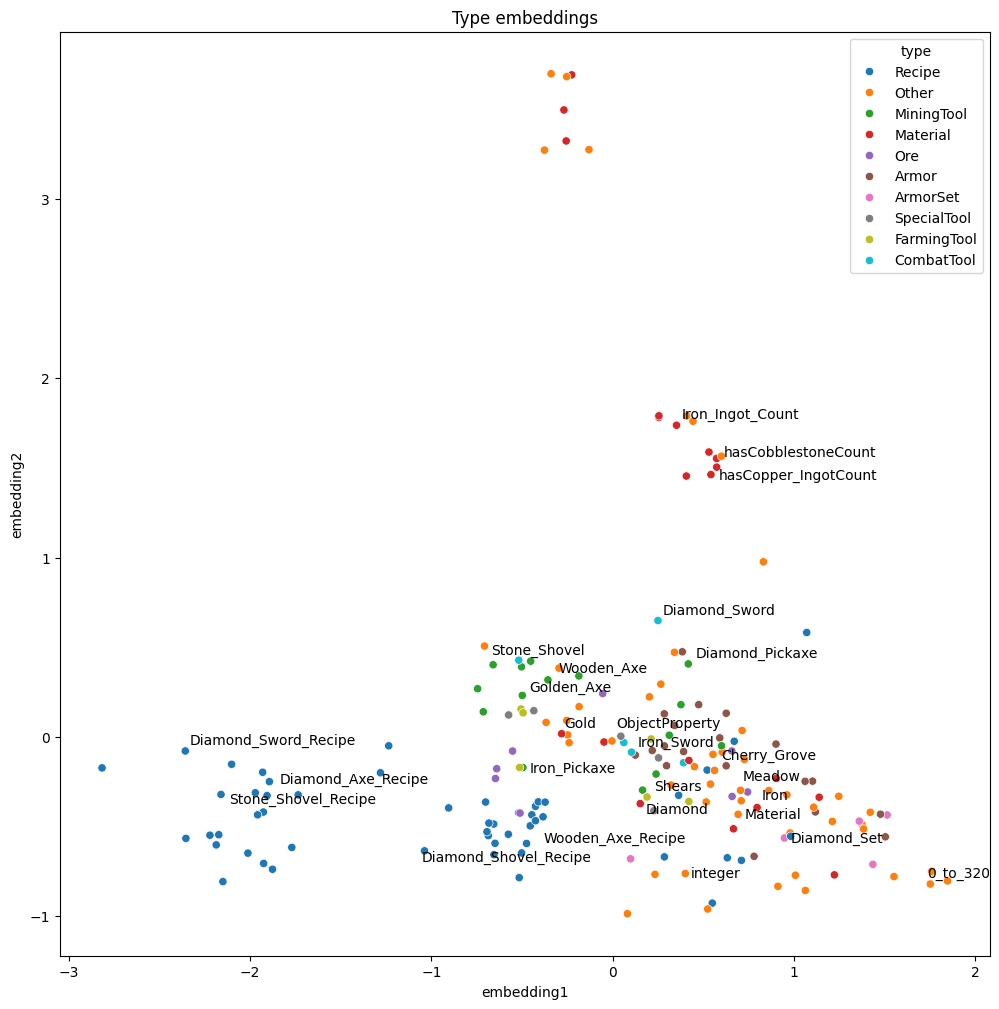

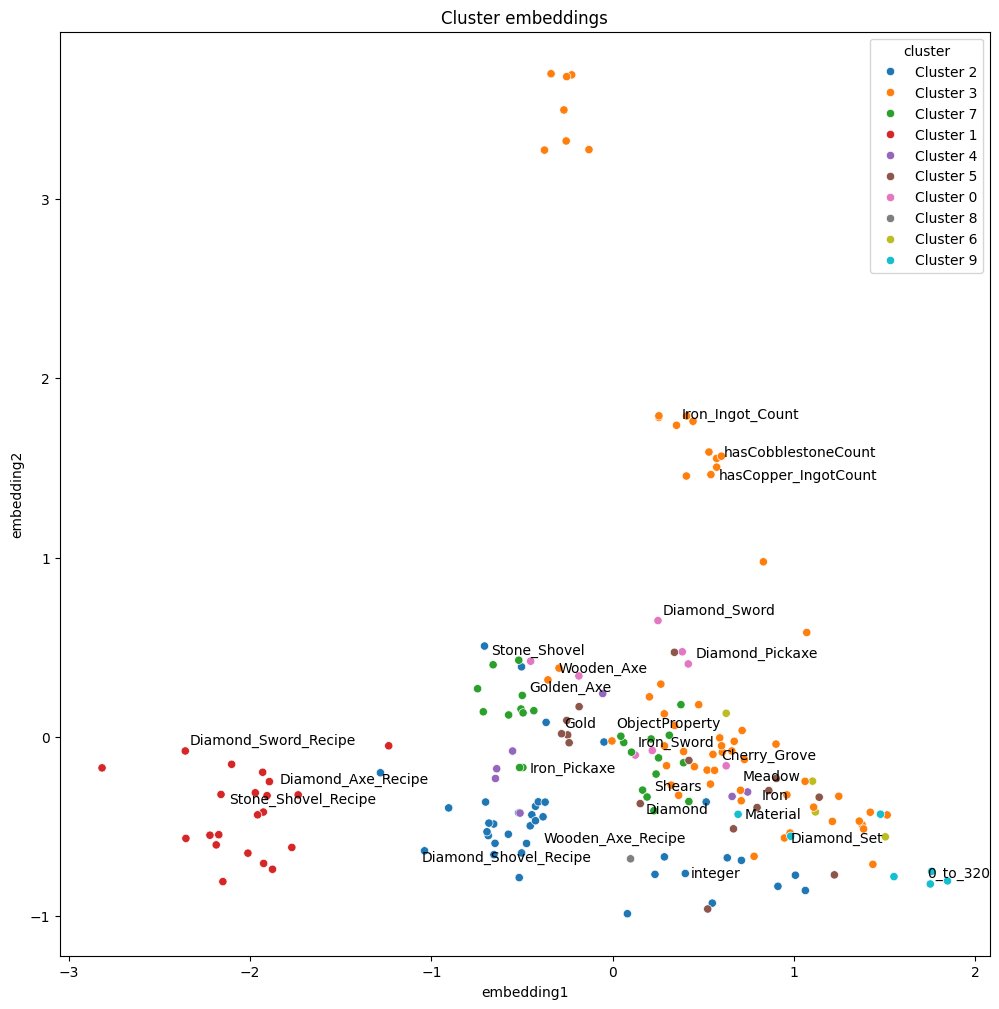

In [8]:

plot_clusters("type")
plt.show()

plot_clusters("cluster")
plt.show()


In [9]:
from sklearn import metrics
metrics.adjusted_rand_score(plot_df.type, plot_df.cluster)

0.2670429678002015

In [10]:
plot_df["results"] = plot_df["cluster"].apply(lambda x: int(x.split()[-1]))  # Example: Convert cluster label to an integer

# Calculate value counts of the results
result_counts = plot_df["results"].value_counts(normalize=True)
print(result_counts)

results
3    0.333333
2    0.198925
7    0.129032
1    0.112903
5    0.080645
0    0.043011
4    0.037634
9    0.037634
6    0.021505
8    0.005376
Name: proportion, dtype: float64


In [11]:
!pip install xgboost

In [12]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
from sklearn.dummy import DummyClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

# Формирование набора данных
X = np.array([items_embeddings[item] for item in items])

# Преобразование меток классов в числовой формат
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(semantic_clusters)

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Обучение модели XGBoost
xgb_model = XGBClassifier(
    n_estimators=500,
    max_depth=5,
    eval_metric='mlogloss',
    objective='multi:softmax',
    num_class=len(np.unique(y))
)
xgb_model.fit(X_train, y_train)

# Оценка точности модели
y_pred = xgb_model.predict(X_test)
xgb_accuracy = accuracy_score(y_test, y_pred)
print(f"XGBoost Accuracy: {xgb_accuracy:.2f}")

# Базовая модель 1: всегда предсказывает наиболее частый класс
dummy_most_frequent = DummyClassifier(strategy="most_frequent")
dummy_most_frequent.fit(X_train, y_train)
y_dummy_pred = dummy_most_frequent.predict(X_test)
dummy_accuracy = accuracy_score(y_test, y_dummy_pred)
print(f"Dummy Most Frequent Accuracy: {dummy_accuracy:.2f}")

print(df)

XGBoost Accuracy: 0.55
Dummy Most Frequent Accuracy: 0.24
                       subject        predicate      object
0        Wooden_Pickaxe_Recipe             type      Recipe
1             Windswept_Forest             type       Biome
2               Wooden_Pickaxe             type        Tool
3           hasIron_IngotCount            range     integer
4                Shears_Recipe  primaryMaterial  Iron_Ingot
..                         ...              ...         ...
483               Brush_Recipe  primaryMaterial     Feather
484  Diamond_Chestplate_Recipe  primaryMaterial     Diamond
485                Stone_Sword             type        Tool
486               Redstone_Ore     foundInLayer   -64_to_16
487       hasCopper_IngotCount           domain      Recipe

[488 rows x 3 columns]
